# MNIST digit classification and sum prediction

### Objective:
Design a neural network that-
1. takes an input image from MNIST dataset.
2. a random number between 0 and 9.

and predicts
1. the number that was represented by the MNIST image.
2. sum of the random number and MNIST number 

### Observations:

### Necessary packages

In [1]:
!pip install idx2numpy

import gzip
import idx2numpy 
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

!pip install torchsummary
from torchsummary import summary
from torchvision import transforms, datasets


  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp37-none-any.whl size=7907 sha256=d5c6cd96718d01bad4d851864b005ea5b83d7417cf90d5548356f4ccb9ab1f3c
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
Successfully built idx2numpy


In [2]:
torch.manual_seed(1)

### Download data

In [3]:
!wget https://data.deepai.org/mnist.zip && unzip mnist.zip && gzip -d *.gz

--2021-05-21 20:04:40--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  5.53MB/s    in 2.0s    

2021-05-21 20:04:43 (5.53 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: train-labels-idx1-ubyte.gz  
  inflating: train-images-idx3-ubyte.gz  
  inflating: t10k-images-idx3-ubyte.gz  
  inflating: t10k-labels-idx1-ubyte.gz  


In [4]:
train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
train_label = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')
print("Training data shape: ", train_images.shape)
print("Training data labels shape: ", train_label.shape)
print("Training data shape: ", test_images.shape)
print("Training data labels shape: ", test_labels.shape)

Training data shape:  (60000, 28, 28)
Training data labels shape:  (60000,)
Training data shape:  (10000, 28, 28)
Training data labels shape:  (10000,)


In [5]:
one_image = train_images[0]
print(one_image.shape)
one_image = np.expand_dims(one_image, axis=2)
print(one_image.shape)

(28, 28)
(28, 28, 1)


### Display sample images

3 5


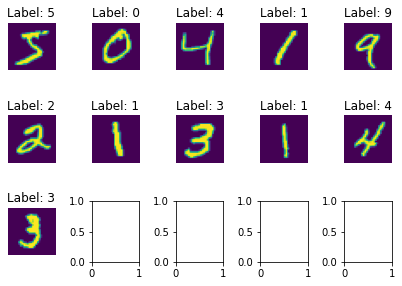

In [6]:
def show_digits_labels(image_list, label_list):
    columns = 5 if len(image_list) >= 5 else len(image_list)
    rows = int(len(image_list)/5 + 1) if len(image_list)%5 > 0 else int(len(image_list)/5)
    print(rows, columns)
    fig, axs = plt.subplots(rows, columns, squeeze=False)
    fig.tight_layout()

    for i in range(len(image_list)):
        # print(i//columns, i%columns)
        # fig.delaxes(axs[-1][-1])
        axs[i//columns][i%columns].axis('off')
        axs[i//columns][i%columns].set_title(f'Label: {label_list[i]}')
        axs[i//columns][i%columns].imshow(image_list[i])

show_digits_labels(train_images[:11], train_label[:11])

### Dataset, transformer and dataloader

#### Custom dataset

To return MNIST image, label, random number and sum of the same random number and MNIST label.

In [7]:
class MNIST_digits_randomNum(Dataset):
    def __init__(self, image_set, label_set, transform = None):
        self.image_set = image_set
        self.label_set = label_set
        self.transform = transform
    
    def __len__(self):
        return len(self.image_set)
    
    def __getitem__(self, idx):
        # Single image is nd.array of shape (H,W). Need data to be in shape -(H x W x C). totensor() transform will then convert into (C x H x W) [0-1] range
        data = np.expand_dims((self.image_set[idx]), axis=2)
        # Need int64 for Runtime error (got scalar type Byte) at CrossEntropyLoss calculation
        target = torch.tensor(self.label_set[idx], dtype=torch.int64)
        rand_num = torch.tensor(np.random.randint(0,10))
        sum_of_digits = target + rand_num

        if self.transform:
            data = self.transform(data)

        return {"data": data, "target": target, "rand_num": rand_num, "sum_of_digits": sum_of_digits}      


#### Transformer

Test transform with totensor and normalization. 

In [8]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [9]:
train_dataset = MNIST_digits_randomNum(train_images, train_label, train_transforms)
test_dataset = MNIST_digits_randomNum(test_images, test_labels, test_transforms)

In [10]:
sample = next(iter(train_dataset))
print("Training set size: ", len(train_dataset))
print("Sample image's shape", sample["data"].shape,  "of type-", type(sample["data"]))
print("Sample image's label: ", sample["target"])
print("Sample random integer of range [0, 9]: ", sample["rand_num"])
print("Sum of sample image's label and generated random integer: ", sample["sum_of_digits"])

test_sample = next(iter(test_dataset))
print("Test set size: ", len(test_dataset))
print("Sample image's shape", test_sample["data"].shape,  "of type-", type(sample["data"]))
print("Sample image's label: ", test_sample["target"])
print("Sample random integer of range [0, 9]: ", test_sample["rand_num"])
print("Sum of sample image's label and generated random integer: ", test_sample["sum_of_digits"])

Training set size:  60000
Sample image's shape torch.Size([1, 28, 28]) of type- <class 'torch.Tensor'>
Sample image's label:  tensor(5)
Sample random integer of range [0, 9]:  tensor(6)
Sum of sample image's label and generated random integer:  tensor(11)
Test set size:  10000
Sample image's shape torch.Size([1, 28, 28]) of type- <class 'torch.Tensor'>
Sample image's label:  tensor(7)
Sample random integer of range [0, 9]:  tensor(7)
Sum of sample image's label and generated random integer:  tensor(14)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [11]:
sample["data"]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [12]:
# Train and test dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [13]:
sample = next(iter(train_loader))
print(sample["target"].shape, sample["rand_num"].shape, sample["sum_of_digits"].shape)
sample["target"], sample["rand_num"], sample["sum_of_digits"], sample["target"].shape, sample["target"][0], sample["target"][0].dtype

torch.Size([128]) torch.Size([128]) torch.Size([128])


(tensor([6, 1, 4, 0, 7, 1, 8, 9, 0, 1, 2, 4, 2, 5, 9, 3, 9, 5, 1, 4, 1, 1, 3, 3,
         2, 4, 3, 7, 8, 8, 1, 1, 4, 5, 4, 5, 0, 1, 0, 0, 7, 3, 7, 5, 0, 4, 1, 5,
         3, 7, 9, 4, 6, 2, 6, 8, 5, 1, 5, 0, 0, 0, 3, 9, 9, 2, 4, 9, 2, 0, 3, 6,
         5, 1, 9, 8, 9, 3, 1, 6, 6, 1, 0, 3, 8, 0, 9, 8, 5, 3, 3, 0, 8, 4, 1, 9,
         7, 0, 2, 4, 8, 4, 7, 8, 5, 6, 1, 8, 5, 8, 3, 5, 0, 3, 0, 4, 7, 4, 3, 8,
         4, 7, 1, 5, 0, 5, 5, 7]),
 tensor([7, 9, 0, 2, 7, 8, 5, 8, 1, 3, 7, 7, 5, 8, 9, 7, 4, 7, 2, 1, 4, 5, 7, 2,
         2, 9, 8, 6, 0, 1, 0, 1, 8, 2, 4, 3, 0, 3, 2, 1, 1, 4, 2, 8, 2, 9, 7, 0,
         2, 8, 5, 4, 2, 1, 2, 0, 8, 3, 4, 8, 1, 8, 9, 7, 4, 4, 7, 2, 5, 4, 1, 5,
         9, 7, 8, 3, 0, 7, 9, 2, 2, 9, 9, 9, 5, 3, 6, 5, 2, 1, 4, 9, 8, 5, 7, 2,
         0, 6, 1, 8, 1, 6, 9, 8, 2, 1, 8, 0, 8, 3, 6, 6, 3, 3, 5, 7, 1, 3, 8, 9,
         7, 4, 6, 6, 8, 8, 6, 0]),
 tensor([13, 10,  4,  2, 14,  9, 13, 17,  1,  4,  9, 11,  7, 13, 18, 10, 13, 12,
          3,  5,  5,  6, 10,  5,  4, 13

In [14]:
print(sample["data"].shape, type(sample["data"]))

torch.Size([128, 1, 28, 28]) <class 'torch.Tensor'>


### CNN model

In [15]:
# Object Recognition
class Net(nn.Module):
    def __init__(self, batch_size, no_of_classes, sum_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.maxpool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=1, padding=0, bias=False),
            )
        
        self.embedding = nn.Embedding(batch_size, no_of_classes)

        self.fc1 = nn.Linear(no_of_classes, no_of_classes)
        self.fc2 = nn.Linear(no_of_classes, 6*no_of_classes)
        self.fc3 = nn.Linear(6*no_of_classes, sum_classes)
    
    def forward(self, img, num):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.maxpool1(img)
        img = self.conv3(img)
        img = self.conv4(img)
        img = self.maxpool2(img)
        img = self.conv5(img)
        img = self.conv6(img)
        img = self.conv7(img)
        img = self.conv8(img)
        img = self.gap(img)
        img = self.conv9(img)
        img = img.view(-1, 10)

        num = self.embedding(num) # shape (batch_size, no_of_classes)
        num = self.fc1(num) # shape (batch_size, no_of_classes)
        num = img + num # Shape (batch_size, no_of_classes)
        num = self.fc2(num)
        num = self.fc3(num)
        # print("Model shape after fc", num.shape)
        # print("Shape of output:", x.shape)
        return img, num   


In [16]:
# Scratch pad
embedding = nn.Embedding(4, 10)
input = torch.LongTensor([i for i in range(4)])
print(embedding(input))

tensor([[-1.4963, -1.9321, -0.2787,  2.7942,  0.5412, -0.7137, -0.6271, -1.7801,
          1.4233, -0.1510],
        [-0.9050, -0.5023, -0.9596,  0.0993, -0.1224,  0.5371,  1.2711,  0.3309,
          0.9404, -0.0993],
        [ 0.5637,  1.3034,  0.2948,  0.4082, -0.6721, -0.0880, -1.8163, -1.0159,
          0.0214, -0.2878],
        [-0.8461, -0.6772,  0.6593,  0.9987, -0.1785, -0.5812,  1.1510,  0.3524,
          1.9520, -0.6267]], grad_fn=<EmbeddingBackward>)


In [17]:
use_cuda = torch.cuda.is_available()
no_of_classes = 10
sum_classes = 19
# hid_dim =
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model = Net(batch_size, no_of_classes, sum_classes).to(device)
# summary(model, input_size=(1, 28, 28), )

Available device: cuda


### Train and Test

In [18]:
# Train
# batch = {"data": data, "target": target, "rand_num": rand_num, "sum_of_digits": sum_of_digits}
def train(model, device, train_loader, optimizer, criterion_digit, criterion_sum):
    model.train()

    # collect stats - for accuracy calculation
    correct_digit = 0
    correct_sum = 0
    processed = 0
    epoch_loss = 0

    epoch_sum_loss = 0
    epoch_digit_loss = 0

    for batch_id, batch in enumerate(train_loader):
        data = batch["data"].to(device)
        target = batch["target"].to(device)
        rand_num = batch["rand_num"].to(device)
        sum_of_digits = batch["sum_of_digits"].to(device)

        optimizer.zero_grad()

        # Gather prediction and calculate loss + backward pass + optimize weights
        digit_pred, sum_pred = model(data, rand_num)
        # print("Train: ", digit_pred.shape)
        digit_loss = criterion_digit(digit_pred, target)
        sum_loss = criterion_sum(sum_pred, sum_of_digits)

        loss = digit_loss + sum_loss

        # Calculate gradients
        loss.backward()
        # Optimizer
        optimizer.step()

        # Metrics calculation- For epoch Accuracy(total correct pred/total items) and loss 
        pred_digit = digit_pred.argmax(dim=1, keepdim=True)
        correct_digit += pred_digit.eq(target.view_as(pred_digit)).sum().item()
        processed += len(data)

        pred_sum = sum_pred.argmax(dim=1, keepdim=True)
        correct_sum += pred_sum.eq(sum_of_digits.view_as(pred_sum)).sum().item()

        epoch_loss += loss.item()
        epoch_digit_loss += digit_loss.item()
        epoch_sum_loss += sum_loss.item()       

    
    epoch_digit_accuracy = (100*correct_digit/processed)
    epoch_sum_accuracy = (100*correct_sum/processed)

    epoch_loss /= len(train_loader)
    print(f"Train set: Epoch Digit Accuracy: {round(epoch_digit_accuracy, 2)} Epoch Sum Accuracy: {round(epoch_sum_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")

    return epoch_digit_accuracy, epoch_sum_accuracy, epoch_loss

In [19]:
# Test
def test(model, device, test_loader, criterion_digit, criterion_sum):
    model.eval()

    # collect stats - for accuracy calculation
    correct_digit = 0
    correct_sum = 0
    processed = 0
    epoch_loss = 0

    epoch_sum_loss = 0
    epoch_digit_loss = 0

    with torch.no_grad():        
        for batch_id, batch in enumerate(test_loader):
            data = batch["data"].to(device)
            target = batch["target"].to(device)
            rand_num = batch["rand_num"].to(device)
            sum_of_digits = batch["sum_of_digits"].to(device)

            digit_pred, sum_pred = model(data, rand_num)
            digit_loss = criterion_digit(digit_pred, target)
            sum_loss = criterion_sum(sum_pred, sum_of_digits)

            loss = digit_loss + sum_loss

            # Metrics calculation
            pred_digit = digit_pred.argmax(dim=1, keepdim=True)
            correct_digit += pred_digit.eq(target.view_as(pred_digit)).sum().item()
            processed += len(data)
            pred_sum = sum_pred.argmax(dim=1, keepdim=True)
            correct_sum += pred_sum.eq(sum_of_digits.view_as(pred_sum)).sum().item()

            epoch_loss += loss.item()
        
    epoch_digit_accuracy = (100*correct_digit/processed)
    epoch_sum_accuracy = (100*correct_sum/processed)

    epoch_loss /= len(test_loader)
    print(f"Test set: Epoch Digit Accuracy: {round(epoch_digit_accuracy, 2)} Epoch Sum Accuracy: {round(epoch_sum_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")
    return epoch_digit_accuracy, epoch_sum_accuracy, epoch_loss

### Model training and validation

In [20]:
EPOCHS = 10
train_digit_accuracy = []
train_sum_accuracy = []
test_digit_accuracy = []
test_sum_accuracy = []
train_loss = []
test_loss = []

# Optimization algorithm from torch.optim
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
# Loss condition
criterion_digit = nn.CrossEntropyLoss()
criterion_sum = nn.CrossEntropyLoss()

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_digit_acc_delta, train_sum_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion_digit, criterion_sum)
    test_digit_acc_delta, test_sum_acc_delta, test_loss_delta = test(model, device, test_loader, criterion_digit, criterion_sum)

    train_digit_accuracy.append(round(train_digit_acc_delta, 2))
    train_sum_accuracy.append(round(train_sum_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_digit_accuracy.append(round(test_digit_acc_delta, 2))
    test_sum_accuracy.append(round(test_sum_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))


Epoch: 0
Train set: Epoch Digit Accuracy: 96.08 Epoch Sum Accuracy: 41.18  Epoch Loss: 1.6582
Test set: Epoch Digit Accuracy: 97.61 Epoch Sum Accuracy: 52.92  Epoch Loss: 1.3373
Epoch: 1
Train set: Epoch Digit Accuracy: 98.9 Epoch Sum Accuracy: 58.24  Epoch Loss: 1.0909
Test set: Epoch Digit Accuracy: 98.98 Epoch Sum Accuracy: 57.97  Epoch Loss: 1.0428
Epoch: 2
Train set: Epoch Digit Accuracy: 99.08 Epoch Sum Accuracy: 67.26  Epoch Loss: 0.9203
Test set: Epoch Digit Accuracy: 99.15 Epoch Sum Accuracy: 72.02  Epoch Loss: 0.8079
Epoch: 3
Train set: Epoch Digit Accuracy: 99.16 Epoch Sum Accuracy: 70.25  Epoch Loss: 0.8553
Test set: Epoch Digit Accuracy: 99.18 Epoch Sum Accuracy: 78.07  Epoch Loss: 0.8435
Epoch: 4
Train set: Epoch Digit Accuracy: 99.29 Epoch Sum Accuracy: 75.56  Epoch Loss: 0.7466
Test set: Epoch Digit Accuracy: 99.15 Epoch Sum Accuracy: 61.13  Epoch Loss: 1.2214
Epoch: 5
Train set: Epoch Digit Accuracy: 99.31 Epoch Sum Accuracy: 77.44  Epoch Loss: 0.7174
Test set: Epoch D

### Test Results

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

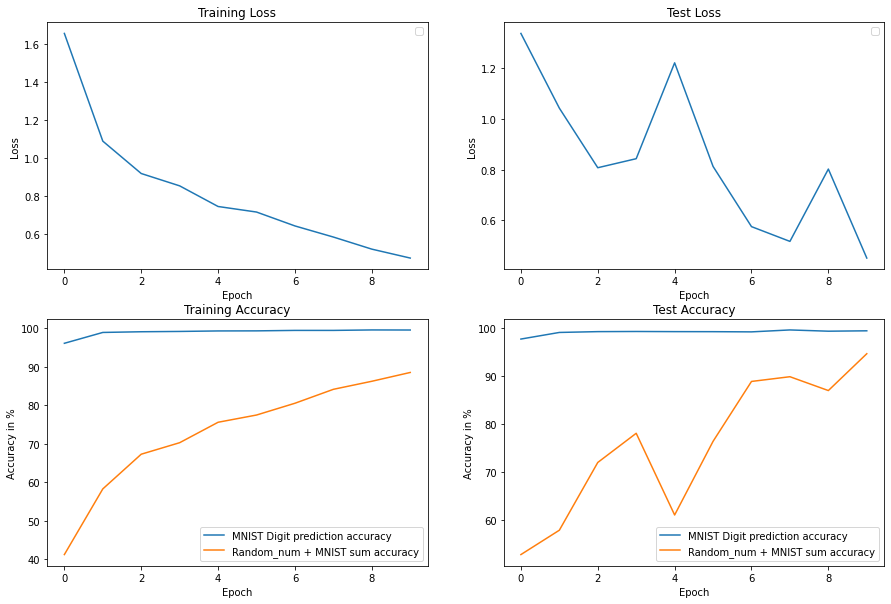

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend(loc="best")

axs[1, 0].plot(train_digit_accuracy, label="MNIST Digit prediction accuracy")
axs[1, 0].plot(train_sum_accuracy, label="Random_num + MNIST sum accuracy")
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy in %")
axs[1, 0].legend(loc="best")

axs[0, 1].plot(test_loss)
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend(loc="best")

axs[1, 1].plot(test_digit_accuracy, label="MNIST Digit prediction accuracy")
axs[1, 1].plot(test_sum_accuracy, label="Random_num + MNIST sum accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy in %")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend(loc="best")
plt.figure()